## 1. Introdução e objetivo

O objetivo do **Monte Carlo Control (On-Policy)** é **aprender uma política ótima** $\pi$ para um ambiente de decisão sequencial **sem um modelo** do ambiente, usando apenas amostras (episódios).

Enquanto os métodos de *Prediction* estimam $V_\pi(s)$ para uma política fixa $\pi$, aqui queremos **aprender e melhorar** a política progressivamente, estimando a função-ação $Q_\pi(s,a)$ e tornando a política **greedy** em relação a $Q$ (com exploração ε-greedy para garantir visitas suficientes a todos os pares $(s,a)$).

Referência: Sutton, R. S. & Barto, A. G. (2018). *Reinforcement Learning: An Introduction*, Capítulo 5.4 (On-Policy First-Visit MC Control).

---

### 1.1 Conceitos principais

- **Função ação-valor**:

$$
Q_\pi(s,a) = \mathbb{E}_\pi\left[ G_t \mid S_t = s, A_t = a \right]
$$

- **Retorno**:

$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots
$$

- **Política ε-greedy** (para melhoria):

$$
\pi(a|s) = \begin{cases}
1 - \varepsilon + \dfrac{\varepsilon}{|\mathcal{A}(s)|}, & \text{se } a = \arg\max_a Q(s,a) \\
\dfrac{\varepsilon}{|\mathcal{A}(s)|}, & \text{caso contrário}
\end{cases}
$$

### 1.2 Pseudocódigo (versão concisa)

```
Inicializar Q(s,a) arbitrariamente (por ex. 0)
Inicializar N(s,a) = 0 (contador de visitas)
Para cada episódio:
    Gerar episódio seguindo a política ε-greedy derivada de Q
    G <- 0
    Para t = T-1 até 0:
        G <- γ * G + R_{t+1}
        Se (S_t, A_t) primeira visita no episódio:
            N(S_t,A_t) <- N(S_t,A_t) + 1
            Q(S_t,A_t) <- Q(S_t,A_t) + (1/N(S_t,A_t)) * (G - Q(S_t,A_t))
            Atualizar política ε-greedy em S_t (tornar ε-greedy em relação a Q)
```

**Observação:** Em implementações práticas, podemos manter a soma acumulada de retornos em vez de armazenar a lista completa de retornos — reduzindo uso de memória.

In [1]:
#! pip install gymnasium

In [2]:
from __future__ import annotations
import numpy as np
from collections import defaultdict
from typing import Callable, Dict, Tuple, List
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Tipagens
State = Tuple[int, int, bool]  # (player_sum, dealer_card, usable_ace) - para Blackjack
Action = int
PolicyFunc = Callable[[State], Action]

In [4]:
# ============================================================================
# FUNÇÕES AUXILIARES
# ============================================================================

def argmax_rand(array):
    """Argmax com quebra de empates aleatória."""
    arr = np.array(array)
    choices = np.flatnonzero(arr == arr.max())
    return int(np.random.choice(choices))

In [5]:
# Política ε-greedy baseada em Q
def epsilon_greedy_from_q(Q: Dict[Tuple, float], state, n_actions: int, eps: float):
    """
    Retorna uma ação escolhida ε-greedy.
    
    Args:
        Q: dicionário com chaves (state, action)
        state: estado atual
        n_actions: número de ações disponíveis
        eps: epsilon
    """
    q_vals = [Q.get((state, a), 0.0) for a in range(n_actions)]
    a_star = argmax_rand(q_vals)
    
    if np.random.rand() > eps:
        return a_star
    else:
        return np.random.choice(range(n_actions))

In [6]:
# Geração de episódio compatível com gymnasium/gym
def generate_episode(env, policy_func: Callable, policy_params: dict):
    """
    Geração de episódio compatível com gymnasium/gym.
    
    Returns:
        trajectory: lista de (state, reward, done, action)
        T: índice do estado terminal
    """
    trajectory = []
    done = True
    At = None
    
    while True:
        if done:
            reset_ret = env.reset()
            # gymnasium: (obs, info), gym old: obs
            St = reset_ret[0] if isinstance(reset_ret, tuple) else reset_ret
            Rt = None
            done = False
        else:
            step_ret = env.step(At)
            if isinstance(step_ret, tuple) and len(step_ret) == 5:
                St, Rt, terminated, truncated, _ = step_ret
                done = bool(terminated or truncated)
            elif isinstance(step_ret, tuple) and len(step_ret) == 4:
                St, Rt, done, _ = step_ret
            elif isinstance(step_ret, tuple) and len(step_ret) == 3:
                St, Rt, done = step_ret
            else:
                St, Rt, done = step_ret[0], step_ret[1], step_ret[2]

        At = policy_func(St, **policy_params)
        trajectory.append((St, Rt, done, At))
        
        if done:
            break
            
    return trajectory, len(trajectory) - 1

In [7]:
# ============================================================================
# ALGORITMO PRINCIPAL
# ============================================================================

def on_policy_first_visit_mc_control(env, episodes: int = 100000, 
                                     gamma: float = 1.0, eps: float = 0.1,
                                     verbose: bool = False):
    """
    Implementação eficiente do On-Policy First-Visit MC Control.
    Usa soma + contador em vez de listas de retornos.
    
    Args:
        env: ambiente Gym/Gymnasium
        episodes: número de episódios de treinamento
        gamma: fator de desconto
        eps: epsilon para política ε-greedy
        verbose: se True, mostra progresso
    
    Returns:
        Q: dicionário Q[(state, action)] -> valor
        avg_max_q_history: histórico de convergência
    """
    Q = defaultdict(float)
    Returns_sum = defaultdict(float)
    Counts = defaultdict(int)

    # Determinar número de ações
    n_actions = getattr(env, 'nb_actions', None)
    if n_actions is None:
        try:
            n_actions = env.action_space.n
        except Exception:
            n_actions = 2

    def policy_for_episode(state, Q_local=Q, eps_local=eps):
        return epsilon_greedy_from_q(Q_local, state, n_actions, eps_local)

    avg_max_q_history = []

    for ep in range(episodes):
        # Gerar episódio
        traj, T = generate_episode(env, policy_for_episode, {})
        G = 0.0
        visited_sa_in_episode = set()

        # Calcular retornos e atualizar Q (primeira visita)
        for t in range(T - 1, -1, -1):
            St, _, _, At = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if t + 1 < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1

            sa = (St, At)
            if sa not in visited_sa_in_episode:
                visited_sa_in_episode.add(sa)
                Counts[sa] += 1
                Returns_sum[sa] += G
                Q[sa] = Returns_sum[sa] / Counts[sa]

        # Calcular métrica de convergência
        if len(Q) > 0:
            state_max = {}
            for (s, a), qv in Q.items():
                state_max[s] = max(state_max.get(s, -np.inf), qv)
            avg_max_q_history.append(np.mean(list(state_max.values())))
        else:
            avg_max_q_history.append(0.0)

        # Progresso
        if verbose and (ep + 1) % max(1, episodes // 10) == 0:
            print(f"Episódios: {ep+1}/{episodes}")

    return Q, avg_max_q_history

In [8]:
def derive_greedy_policy(Q, n_actions=2):
    """Deriva política greedy a partir de Q."""
    policy = {}
    state_actions = defaultdict(dict)
    
    for (s, a), qv in Q.items():
        state_actions[s][a] = qv
        
    for s, actions in state_actions.items():
        qvals = [actions.get(a, -np.inf) for a in range(n_actions)]
        policy[s] = argmax_rand(qvals)
        
    return policy

In [9]:
def q_to_v_approx(Q, n_actions=2):
    """Aproximação de V(s) a partir de Q: V(s) ≈ max_a Q(s,a)"""
    state_max = {}
    for (s, a), qv in Q.items():
        state_max[s] = max(state_max.get(s, -np.inf), qv)
    return state_max

## Visualizações e utilitários de plot

As próximas células contêm funções para visualizar Q, V (aprox.) e políticas.

In [10]:
# ============================================================================
# FUNÇÕES DE VISUALIZAÇÃO
# ============================================================================

def value_dict_to_array(V_dict, has_ace: bool):
    """Converte V(s) dict para matriz 10x10."""
    Vd = defaultdict(float, V_dict)
    arr = np.zeros((10, 10))
    for ps in range(12, 22):
        for dc in range(1, 11):
            arr[ps - 12, dc - 1] = Vd.get((ps, dc, has_ace), 0.0)
    return arr

In [11]:
# Plot heatmaps for V(s) approximated from Q (max_a Q)
def plot_q_value_heatmap(Q, title_prefix: str = '', state_values: bool = False, 
                         fmt: str = '.2f', n_actions: int = 2):
    """
    Plota heatmaps de V(s) aproximado a partir de Q.
    """
    V_approx = q_to_v_approx(Q, n_actions)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for ax, ace in zip(axes, [True, False]):
        data = value_dict_to_array(V_approx, ace)
        im = ax.imshow(data, origin='lower', extent=[0.5, 10.5, 11.5, 21.5], 
                      aspect='auto', cmap='viridis')
        ax.set_title(f"{title_prefix}V(s) - usable_ace={ace}", fontsize=12)
        ax.set_xlabel('Carta visível do dealer', fontsize=10)
        ax.set_ylabel('Soma do jogador', fontsize=10)
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))
        
        if state_values:
            nrows, ncols = data.shape
            for i in range(nrows):
                for j in range(ncols):
                    color = 'white' if data[i, j] < 0 else 'black'
                    ax.text(j + 1, i + 12, format(data[i, j], fmt), 
                           ha='center', va='center', fontsize=7, color=color)
        
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

In [12]:
# Plot policy heatmap (action: 0 stick, 1 hit)
def plot_policy_heatmap(policy_greedy, title: str = 'Política (greedy)', 
                       state_values: bool = False):
    """
    Plota mapa da política greedy (0=stick, 1=hit).
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for ax, ace in zip(axes, [True, False]):
        arr = np.zeros((10, 10))
        for ps in range(12, 22):
            for dc in range(1, 11):
                val = policy_greedy.get((ps, dc, ace), 0)
                arr[ps - 12, dc - 1] = val
        
        im = ax.imshow(arr, origin='lower', extent=[0.5, 10.5, 11.5, 21.5], 
                      aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
        ax.set_title(f"{title} - usable_ace={ace}", fontsize=12)
        ax.set_xlabel('Carta visível do dealer', fontsize=10)
        ax.set_ylabel('Soma do jogador', fontsize=10)
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))
        
        if state_values:
            nrows, ncols = arr.shape
            for i in range(nrows):
                for j in range(ncols):
                    action_text = 'HIT' if arr[i, j] == 1 else 'STICK'
                    ax.text(j + 1, i + 12, action_text, ha='center', 
                           va='center', fontsize=6, color='black', weight='bold')
        
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_ticks([0, 1])
        cbar.set_ticklabels(['STICK', 'HIT'])
    
    plt.tight_layout()
    plt.show()

In [13]:
def plot_convergence_history(history, title: str = 'Convergência', 
                            window: int = 100):
    """
    Plota histórico de convergência com média móvel.
    MELHORADO com média móvel para visualização mais clara.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Gráfico 1: Série completa
    ax1.plot(history, alpha=0.3, linewidth=0.5, label='Valores brutos')
    
    # Média móvel
    if len(history) > window:
        moving_avg = np.convolve(history, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(history)), moving_avg, 
                linewidth=2, color='red', label=f'Média móvel ({window} ep)')
    
    ax1.set_xlabel('Episódios', fontsize=10)
    ax1.set_ylabel('Avg max Q (por estado)', fontsize=10)
    ax1.set_title(f'{title} - Série Temporal Completa', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Gráfico 2: Últimos 20% dos episódios (zoom)
    start_idx = max(0, int(len(history) * 0.8))
    ax2.plot(range(start_idx, len(history)), history[start_idx:], 
            linewidth=1, alpha=0.7)
    ax2.set_xlabel('Episódios', fontsize=10)
    ax2.set_ylabel('Avg max Q', fontsize=10)
    ax2.set_title(f'{title} - Últimos 20% dos Episódios (Zoom)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [14]:
def value_dict_to_dataframe(V_dict, has_ace: bool) -> pd.DataFrame:
    """Converte V(s) dict em DataFrame pandas."""
    index = list(range(12, 22))
    cols = list(range(1, 11))
    data = []
    
    for ps in index:
        row = []
        for dc in cols:
            row.append(V_dict.get((ps, dc, has_ace), np.nan))
        data.append(row)
        
    df = pd.DataFrame(data, index=index, columns=cols)
    df.index.name = 'player_sum'
    df.columns.name = 'dealer_card'
    return df

## Execução / Exemplo de uso

A célula abaixo executa o algoritmo no ambiente Blackjack. Ajuste `episodes` conforme seus recursos.

In [15]:
#Criar ambiente
try:
    import gymnasium as gym
    env = gym.make('Blackjack-v1')
    print("✓ Usando Gymnasium")
except Exception:
    import gym
    env = gym.make('Blackjack-v0')
    print("✓ Usando Gym")

✓ Usando Gymnasium


In [16]:
# Configurar nb_actions
if not hasattr(env, 'nb_actions'):
    try:
        env.nb_actions = env.action_space.n
    except Exception:
        env.nb_actions = 2

print(f"✓ Ambiente: {env}")
print(f"✓ Ações disponíveis: {env.nb_actions}")

✓ Ambiente: <OrderEnforcing<PassiveEnvChecker<BlackjackEnv<Blackjack-v1>>>>
✓ Ações disponíveis: 2


In [17]:
%%time
# Parâmetros
GAMMA = 1.0
EPSILON = 0.1
EPISODES = 100000

print(f"\nParâmetros:")
print(f"  - Episódios: {EPISODES:,}")
print(f"  - Gamma (γ): {GAMMA}")
print(f"  - Epsilon (ε): {EPSILON}")

# Treinar
print(f"\nIniciando treinamento...")
Q, history = on_policy_first_visit_mc_control(
    env, 
    episodes=EPISODES, 
    gamma=GAMMA, 
    eps=EPSILON,
    verbose=True
)
# Derivar política
policy_greedy = derive_greedy_policy(Q, n_actions=env.nb_actions)

print(f"\n✓ Treinamento concluído!")
print(f"✓ Estados únicos visitados: {len(set(s for (s, a) in Q.keys()))}")
print(f"✓ Pares (estado, ação) visitados: {len(Q)}")


Parâmetros:
  - Episódios: 100,000
  - Gamma (γ): 1.0
  - Epsilon (ε): 0.1

Iniciando treinamento...
Episódios: 10000/100000
Episódios: 20000/100000
Episódios: 30000/100000
Episódios: 40000/100000
Episódios: 50000/100000
Episódios: 60000/100000
Episódios: 70000/100000
Episódios: 80000/100000
Episódios: 90000/100000
Episódios: 100000/100000

✓ Treinamento concluído!
✓ Estados únicos visitados: 280
✓ Pares (estado, ação) visitados: 560



Gerando visualizações...


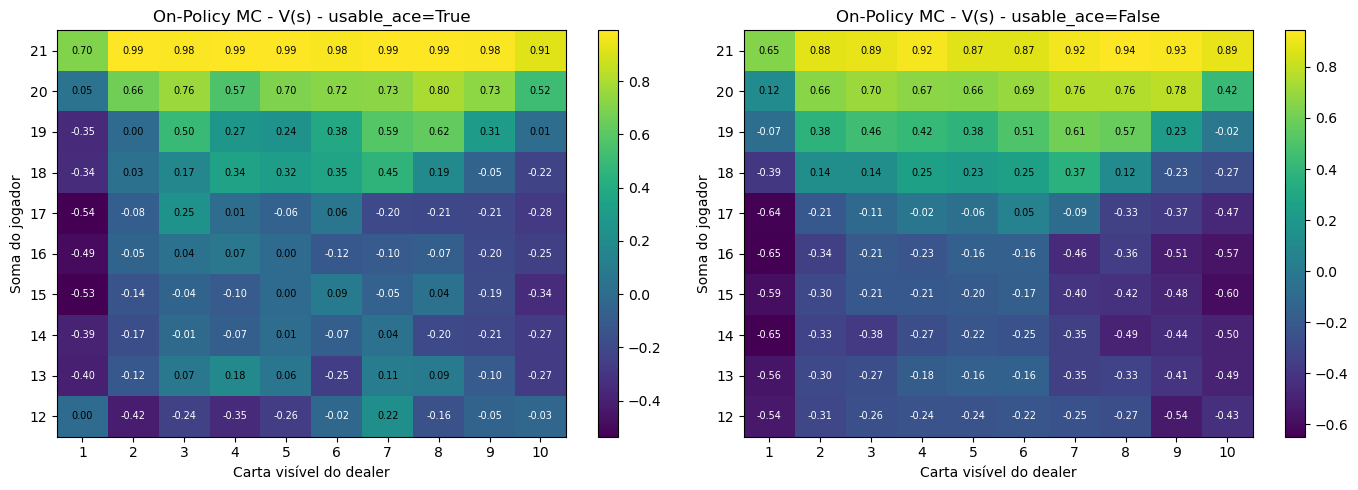

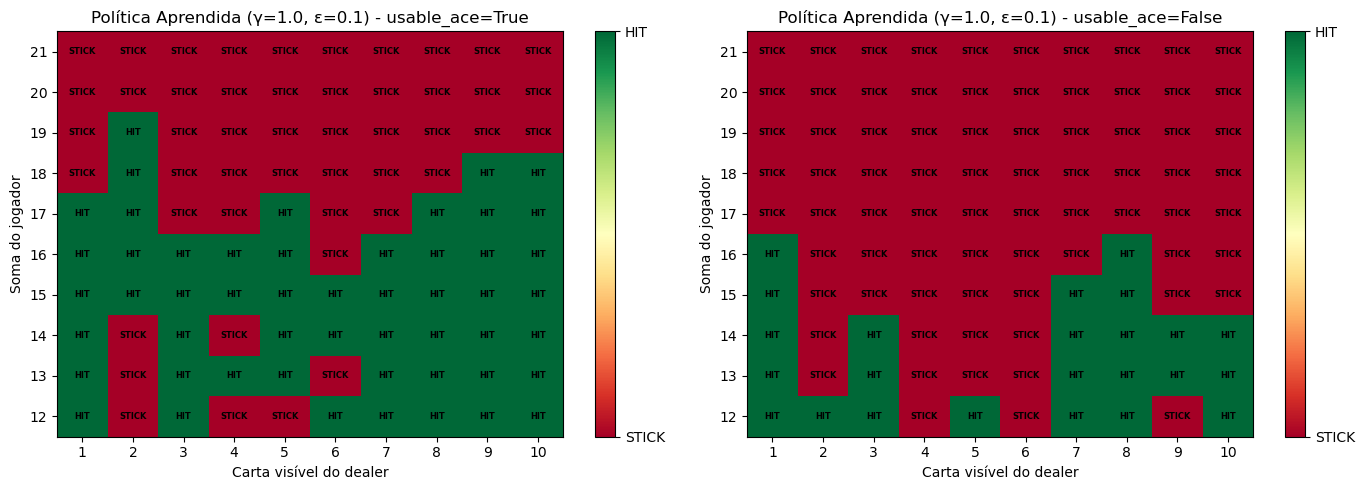

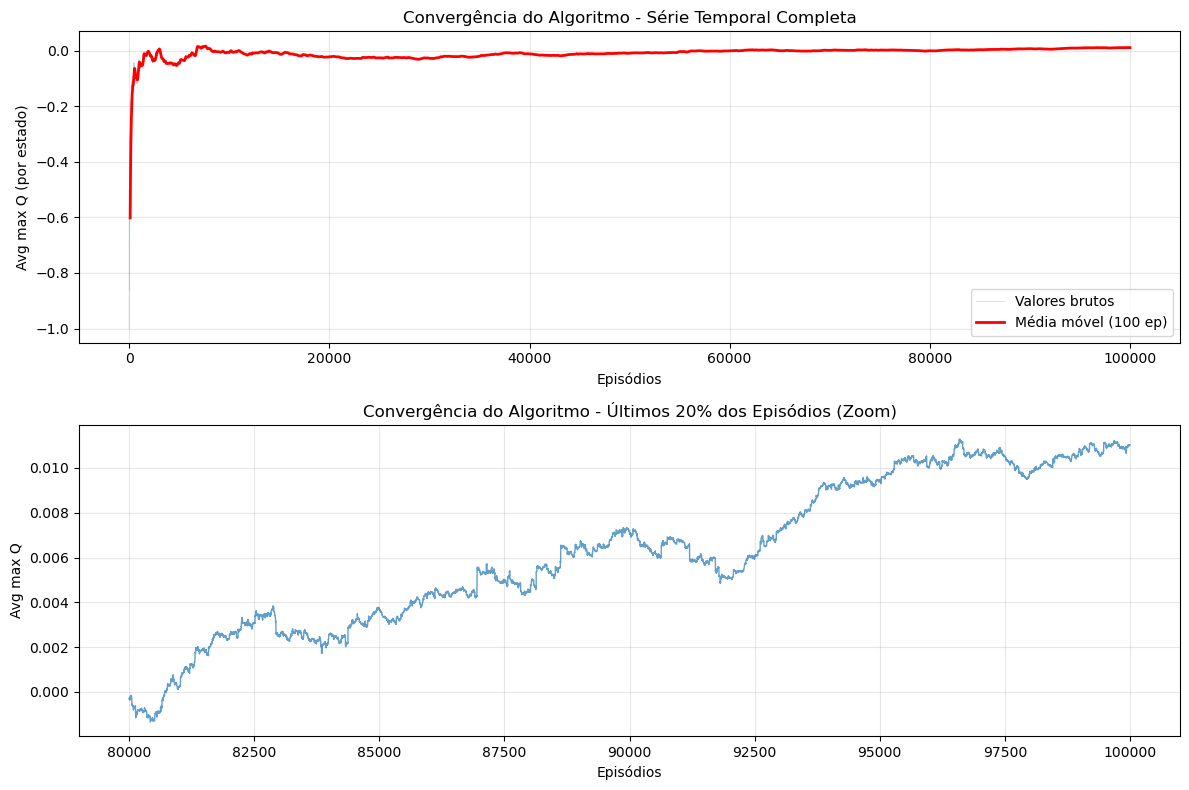


 RESULTADOS FINAIS
Valor médio aproximado: 0.0110
Valor mínimo: -0.7727
Valor máximo: 0.9903

V(s) aproximado – usable_ace = True
dealer_card        1         2         3         4         5         6         7         8         9         10
player_sum                                                                                                     
12           0.000000 -0.419355 -0.236842 -0.350000 -0.257143 -0.023256  0.222222 -0.159091 -0.048780 -0.030120
13          -0.400000 -0.118280  0.073529  0.180723  0.064516 -0.250000  0.107143  0.086957 -0.098901 -0.266272
14          -0.385714 -0.166667 -0.010417 -0.074074  0.012195 -0.071429  0.037975 -0.196970 -0.212766 -0.265252
15          -0.530000 -0.138462 -0.044444 -0.098039  0.000000  0.092784 -0.054054  0.037500 -0.188679 -0.340050
16          -0.490196 -0.045455  0.035398  0.071429  0.000000 -0.115385 -0.095238 -0.070866 -0.198473 -0.248120
17          -0.535714 -0.082353  0.250000  0.008929 -0.057692  0.064815 -0.198413 -0.

In [18]:
# Visualizar
print(f"\nGerando visualizações...")

plot_q_value_heatmap(Q, title_prefix='On-Policy MC - ', 
                    state_values=True, fmt='.2f', n_actions=env.nb_actions)

plot_policy_heatmap(policy_greedy, 
                   title=f'Política Aprendida (γ={GAMMA}, ε={EPSILON})',
                   state_values=True)

plot_convergence_history(history, title='Convergência do Algoritmo')

# Estatísticas
V_approx = q_to_v_approx(Q, n_actions=env.nb_actions)

print("\n" + "="*70)
print(" RESULTADOS FINAIS")
print("="*70)
print(f"Valor médio aproximado: {np.mean(list(V_approx.values())):.4f}")
print(f"Valor mínimo: {min(V_approx.values()):.4f}")
print(f"Valor máximo: {max(V_approx.values()):.4f}")

# Tabelas
df_true = value_dict_to_dataframe(V_approx, has_ace=True)
df_false = value_dict_to_dataframe(V_approx, has_ace=False)

print('\n' + '='*70)
print('V(s) aproximado – usable_ace = True')
print('='*70)
print(df_true.to_string())

print('\n' + '='*70)
print('V(s) aproximado – usable_ace = False')
print('='*70)
print(df_false.to_string())

print("\n" + "="*70)
print(" ANÁLISE COMPLETA FINALIZADA!")
print("="*70)

In [19]:
def calcular_taxa_vitorias(env, policy, n_jogos=10000):
    """Calcula taxa de vitórias de uma política."""
    vitorias = 0
    empates = 0
    derrotas = 0
    
    for _ in range(n_jogos):
        # Resetar jogo
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        done = False
        
        # Jogar até terminar
        while not done:
            # Escolher ação pela política (padrão: STICK se não conhece)
            action = policy.get(state, 0)
            
            # Executar ação
            result = env.step(action)
            if len(result) == 5:  # gymnasium
                state, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:  # gym
                state, reward, done, _ = result
        
        # Contar resultado
        if reward > 0:
            vitorias += 1
        elif reward < 0:
            derrotas += 1
        else:
            empates += 1
    
    taxa_vitoria = (vitorias / n_jogos) * 100
    
    print(f"\n{'='*50}")
    print(f"Resultados de {n_jogos} jogos:")
    print(f"{'='*50}")
    print(f"Vitórias:  {vitorias:>6} ({taxa_vitoria:>5.2f}%)")
    print(f"Derrotas:  {derrotas:>6} ({(derrotas/n_jogos)*100:>5.2f}%)")
    print(f"Empates:   {empates:>6} ({(empates/n_jogos)*100:>5.2f}%)")
    print(f"{'='*50}")
    
    return taxa_vitoria

In [20]:
taxa = calcular_taxa_vitorias(env, policy=policy_greedy, n_jogos=10000)


Resultados de 10000 jogos:
Vitórias:    4356 (43.56%)
Derrotas:    4820 (48.20%)
Empates:      824 ( 8.24%)
